In [12]:
import numpy as np
import pandas as pd
import chardet
import csv
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import os
import re

In [13]:
def analyze_and_clean_csv_by_column_distribution(input_file, output_file=None, 
                                               iqr_factor=1.5, mode_range=2,
                                               min_valid_rows=3, show_plot=True):
    """
    通过分析列数分布来清理CSV文件，始终保留第一行（标题行）
    
    参数:
    input_file: 输入CSV文件路径
    output_file: 输出文件路径（如果不提供，则不保存结果）
    iqr_factor: IQR方法的乘数因子（默认1.5）
    mode_range: 基于众数的范围（默认±2列）
    min_valid_rows: 有效行的最小数量（用于过滤空行）
    show_plot: 是否显示列数分布图
    """
    # 检测文件编码
    with open(input_file, 'rb') as f:
        result = chardet.detect(f.read(10000))  # 只读取前10000字节来检测编码
    encoding = result['encoding'] or 'utf-8'
    confidence = result['confidence']
    print(f"检测到的文件编码: {encoding} (置信度: {confidence:.2%})")
    
    # 逐行读取文件并计算每行的列数
    row_lengths = []
    total_rows = 0
    header = None
    header_length = 0
    
    # 尝试多种编码方式
    encodings_to_try = [encoding, 'utf-8', 'latin-1', 'gbk', 'big5']
    successful_encoding = None
    
    for enc in encodings_to_try:
        try:
            with open(input_file, 'r', encoding=enc, errors='replace') as f:
                reader = csv.reader(f)
                # 读取第一行作为标题行
                header = next(reader, None)
                if header is None:
                    continue
                    
                # 计算标题行的有效列数（非空）
                header_length = len([cell for cell in header if cell.strip() != ''])
                print(f"标题行列数: {header_length}")
                
                # 处理剩余行
                for row in reader:
                    total_rows += 1
                    # 计算该行的有效列数（非空）
                    length = len([cell for cell in row if cell.strip() != ''])
                    row_lengths.append(length)
            successful_encoding = enc
            break
        except Exception as e:
            print(f"尝试编码 {enc} 时出错: {e}")
            continue
    
    if successful_encoding is None or header is None:
        raise ValueError("无法用常见编码读取文件或文件为空")
    
    print(f"使用编码 {successful_encoding} 成功读取文件")
    print(f"总共处理了 {total_rows + 1} 行（包含1行标题行）")
    
    if not row_lengths:
        print("无法从文件中提取任何有效数据行")
        return None, None
    
    # 转换为numpy数组以便分析
    row_lengths = np.array(row_lengths)
    
    # 统计列数分布
    count_distribution = Counter(row_lengths)
    print("\n数据行列数分布统计:")
    for count, freq in sorted(count_distribution.items()):
        print(f"列数 {count}: {freq} 行 ({freq/total_rows:.2%})")
    
    # 绘制列数分布图
    if show_plot:
        plt.figure(figsize=(14, 7))
        ax = sns.histplot(row_lengths, bins=range(min(row_lengths), max(row_lengths)+1), kde=True)
        plt.title('每行数据列数分布（不含标题行）', fontsize=16)
        plt.xlabel('列数', fontsize=12)
        plt.ylabel('行数', fontsize=12)
        plt.grid(axis='y', alpha=0.75)
        
        # 标记统计信息
        mean = np.mean(row_lengths)
        median = np.median(row_lengths)
        mode = Counter(row_lengths).most_common(1)[0][0]
        
        plt.axvline(mean, color='r', linestyle='--', label=f'均值: {mean:.1f}')
        plt.axvline(median, color='g', linestyle='--', label=f'中位数: {median}')
        plt.axvline(mode, color='b', linestyle='--', label=f'众数: {mode}')
        plt.axvline(header_length, color='purple', linestyle='--', label=f'标题行列数: {header_length}')
        plt.legend()
        
        plt.tight_layout()
        plt.show()
    
    # 计算统计量
    mean = np.mean(row_lengths)
    median = np.median(row_lengths)
    mode = Counter(row_lengths).most_common(1)[0][0]
    std = np.std(row_lengths)
    
    print(f"\n统计信息（仅数据行）:")
    print(f"平均列数: {mean:.2f}")
    print(f"中位数列数: {median}")
    print(f"众数列数: {mode}")
    print(f"标准差: {std:.2f}")
    
    # 方法1：使用IQR（四分位距）
    Q1 = np.percentile(row_lengths, 25)
    Q3 = np.percentile(row_lengths, 75)
    IQR = Q3 - Q1
    iqr_lower = max(min_valid_rows, Q1 - iqr_factor * IQR)  # 确保下限至少为min_valid_rows
    iqr_upper = Q3 + iqr_factor * IQR
    
    # 方法2：使用众数附近的范围
    mode_lower = max(min_valid_rows, mode - mode_range)
    mode_upper = mode + mode_range
    
    # 选择更严格的区间
    final_lower = max(int(iqr_lower), int(mode_lower))
    final_upper = min(int(iqr_upper), int(mode_upper))
    
    print(f"\n基于IQR方法的合理列数区间: [{int(iqr_lower)}, {int(iqr_upper)}]")
    print(f"基于众数的合理列数区间: [{mode_lower}, {mode_upper}]")
    print(f"\n最终采用的合理列数区间: [{final_lower}, {final_upper}]")
    
    # 计算在这个区间内的行数（始终保留标题行）
    valid_mask = (row_lengths >= final_lower) & (row_lengths <= final_upper)
    valid_count = np.sum(valid_mask)
    
    # 添加标题行（始终保留）
    all_valid_mask = np.insert(valid_mask, 0, True)  # 在索引0处插入True（标题行）
    
    print(f"\n在合理区间内的数据行数: {valid_count} ({valid_count/total_rows:.2%})")
    print(f"需要删除的数据行数: {total_rows - valid_count} ({(total_rows - valid_count)/total_rows:.2%})")
    print(f"总保留行数: {valid_count + 1}（包含标题行）")
    
    # 如果需要，清理并保存文件
    if output_file:
        try:
            # 重新读取文件并只保存有效行
            valid_rows = []
            with open(input_file, 'r', encoding=successful_encoding, errors='replace') as f:
                reader = csv.reader(f)
                # 始终添加标题行
                valid_rows.append(next(reader))
                
                # 处理数据行
                current_idx = 0
                for row in reader:
                    if current_idx < len(valid_mask) and valid_mask[current_idx]:
                        valid_rows.append(row)
                    current_idx += 1
            
            # 保存清理后的文件
            with open(output_file, 'w', newline='', encoding='utf-8-sig') as f:
                writer = csv.writer(f)
                writer.writerows(valid_rows)
            
            print(f"\n清理后的文件已保存至: {output_file}")
        except Exception as e:
            print(f"保存清理后的文件时出错: {e}")
    
    return (final_lower, final_upper), all_valid_mask

检测到的文件编码: Windows-1252 (置信度: 73.00%)
标题行列数: 100
使用编码 Windows-1252 成功读取文件
总共处理了 18215 行（包含1行标题行）

数据行列数分布统计:
列数 0: 17 行 (0.09%)
列数 7: 1 行 (0.01%)
列数 8: 1 行 (0.01%)
列数 9: 1 行 (0.01%)
列数 13: 4 行 (0.02%)
列数 14: 3 行 (0.02%)
列数 46: 1 行 (0.01%)
列数 47: 2 行 (0.01%)
列数 51: 2 行 (0.01%)
列数 52: 2 行 (0.01%)
列数 53: 1 行 (0.01%)
列数 54: 7 行 (0.04%)
列数 55: 21 行 (0.12%)
列数 56: 25 行 (0.14%)
列数 57: 47 行 (0.26%)
列数 58: 89 行 (0.49%)
列数 59: 137 行 (0.75%)
列数 60: 152 行 (0.83%)
列数 61: 219 行 (1.20%)
列数 62: 697 行 (3.83%)
列数 63: 606 行 (3.33%)
列数 64: 635 行 (3.49%)
列数 65: 332 行 (1.82%)
列数 66: 226 行 (1.24%)
列数 67: 128 行 (0.70%)
列数 68: 263 行 (1.44%)
列数 69: 427 行 (2.34%)
列数 70: 421 行 (2.31%)
列数 71: 372 行 (2.04%)
列数 72: 1669 行 (9.16%)
列数 73: 2363 行 (12.97%)
列数 74: 2804 行 (15.39%)
列数 75: 2110 行 (11.58%)
列数 76: 2799 行 (15.37%)
列数 77: 1620 行 (8.89%)
列数 78: 4 行 (0.02%)
列数 79: 2 行 (0.01%)
列数 80: 1 行 (0.01%)
列数 81: 3 行 (0.02%)


C:\Users\lenovo\AppData\Local\Temp\ipykernel_6984\94870593.py:96: UserWarning: Glyph 21015 (\N{CJK UNIFIED IDEOGRAPH-5217}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\lenovo\AppData\Local\Temp\ipykernel_6984\94870593.py:96: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\lenovo\AppData\Local\Temp\ipykernel_6984\94870593.py:96: UserWarning: Glyph 34892 (\N{CJK UNIFIED IDEOGRAPH-884C}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\lenovo\AppData\Local\Temp\ipykernel_6984\94870593.py:96: UserWarning: Glyph 27599 (\N{CJK UNIFIED IDEOGRAPH-6BCF}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\lenovo\AppData\Local\Temp\ipykernel_6984\94870593.py:96: UserWarning: Glyph 25454 (\N{CJK UNIFIED IDEOGRAPH-636E}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\lenovo\AppData\Local\Temp\ipykernel_6984\94870593.py:96: UserWarning: Glyph 20998 (\N{CJK UNIFIE

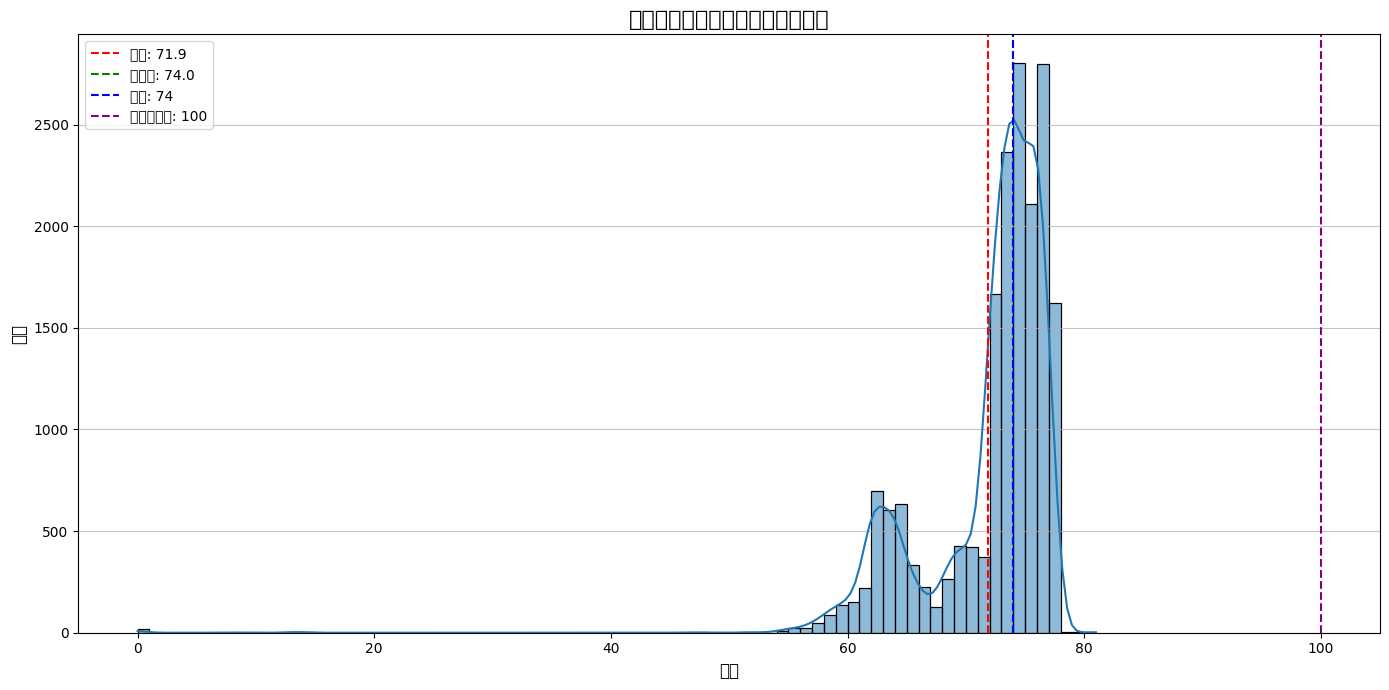


统计信息（仅数据行）:
平均列数: 71.86
中位数列数: 74.0
众数列数: 74
标准差: 5.53

基于IQR方法的合理列数区间: [65, 81]
基于众数的合理列数区间: [72, 76]

最终采用的合理列数区间: [72, 76]

在合理区间内的数据行数: 11745 (64.48%)
需要删除的数据行数: 6469 (35.52%)
总保留行数: 11746（包含标题行）

清理后的文件已保存至: cleaned_data.csv


In [14]:
if __name__ == "__main__":
    # 分析并清理CSV文件，始终保留标题行
    valid_range, valid_mask = analyze_and_clean_csv_by_column_distribution(
        'listings.csv', 
        'cleaned_data.csv',
        iqr_factor=1.5,
        mode_range=2,
        min_valid_rows=3
    )

Drop the columns that behind 'reviews_per_month', they are useless.

In [15]:
df = pd.read_csv("cleaned_data.csv", low_memory=False)
if 'reviews_per_month' in df.columns:
    idx = df.columns.get_loc('reviews_per_month') + 1
    df = df.iloc[:, :idx]
    df.to_csv("cleaned_data.csv", index=False)

Drop the rows whose 'price' is na.

In [16]:
filtered_data = pd.read_csv("cleaned_data.csv")
filtered_data = filtered_data[
    (filtered_data['price'].notna()) & 
    (filtered_data['price'] != '') & 
    (pd.notna(filtered_data['price']))
]

Check the prices distribution.

数据形状: (11745, 79)
列名: ['id', 'listing_url', 'scrape_id', 'last_scraped', 'source', 'name', 'description', 'neighborhood_overview', 'picture_url', 'host_id', 'host_url', 'host_name', 'host_since', 'host_location', 'host_about', 'host_response_time', 'host_response_rate', 'host_acceptance_rate', 'host_is_superhost', 'host_thumbnail_url', 'host_picture_url', 'host_neighbourhood', 'host_listings_count', 'host_total_listings_count', 'host_verifications', 'host_has_profile_pic', 'host_identity_verified', 'neighbourhood', 'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'latitude', 'longitude', 'property_type', 'room_type', 'accommodates', 'bathrooms', 'bathrooms_text', 'bedrooms', 'beds', 'amenities', 'price', 'minimum_nights', 'maximum_nights', 'minimum_minimum_nights', 'maximum_minimum_nights', 'minimum_maximum_nights', 'maximum_maximum_nights', 'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm', 'calendar_updated', 'has_availability', 'availability_30', 'availability_60', 'availa

C:\Users\lenovo\AppData\Local\Temp\ipykernel_6984\2400856180.py:153: UserWarning: Glyph 39057 (\N{CJK UNIFIED IDEOGRAPH-9891}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\lenovo\AppData\Local\Temp\ipykernel_6984\2400856180.py:153: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\lenovo\AppData\Local\Temp\ipykernel_6984\2400856180.py:153: UserWarning: Glyph 20998 (\N{CJK UNIFIED IDEOGRAPH-5206}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\lenovo\AppData\Local\Temp\ipykernel_6984\2400856180.py:153: UserWarning: Glyph 24067 (\N{CJK UNIFIED IDEOGRAPH-5E03}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\lenovo\AppData\Local\Temp\ipykernel_6984\2400856180.py:153: UserWarning: Glyph 30452 (\N{CJK UNIFIED IDEOGRAPH-76F4}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\lenovo\AppData\Local\Temp\ipykernel_6984\2400856180.py:153: UserWarning: Glyph 26

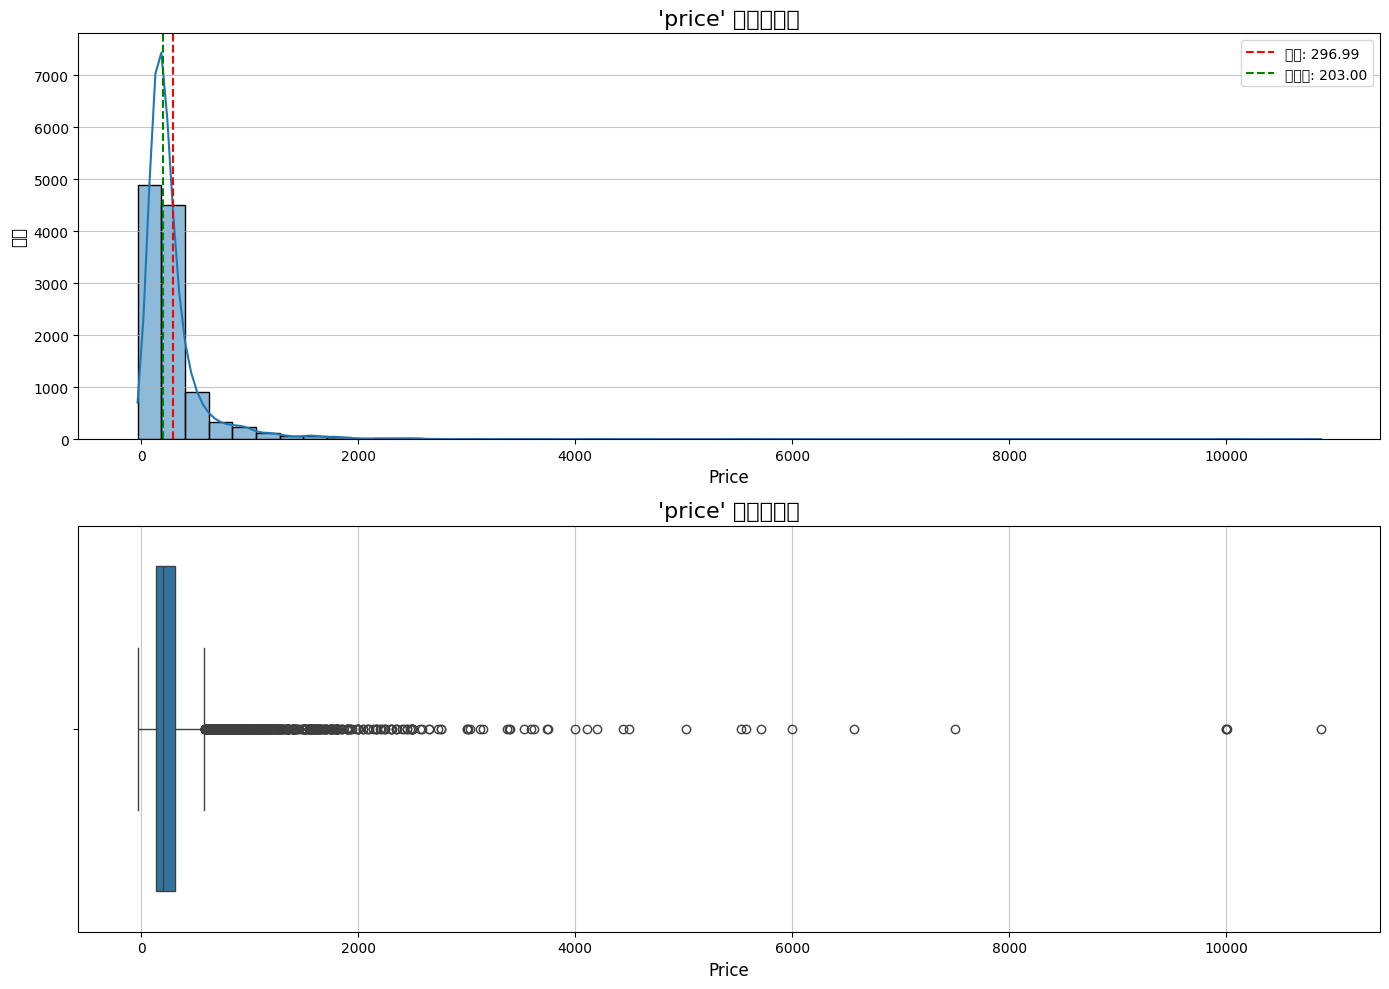


异常值分析:
四分位距(IQR): 179.00
异常值下限: -133.50
异常值上限: 582.50
异常值数量: 1024 (9.13% of data)
最小异常值: 583.00
最大异常值: 10872.00

已保存price > 0的数据到 'cleaned_data.csv' (共 11217 行)


In [17]:
def analyze_price_distribution(file_path):
    """
    分析并可视化price列的分布
    
    参数:
    file_path: CSV文件路径
    
    返回:
    price列的基本统计信息
    """
    # 读取CSV文件，处理混合类型警告
    df = pd.read_csv(file_path, low_memory=False)
    
    print(f"数据形状: {df.shape}")
    print(f"列名: {df.columns.tolist()}")
    
    # 尝试找到price列
    price_col = None
    
    # 1. 首先尝试精确匹配'price'
    if 'price' in df.columns:
        price_col = 'price'
        print("找到精确匹配的'price'列")
    
    # 2. 尝试不区分大小写的匹配
    if price_col is None:
        for col in df.columns:
            if col.lower() == 'price':
                price_col = col
                print(f"找到不区分大小写的'price'匹配: '{col}'")
                break
    
    # 3. 尝试包含'price'的匹配
    if price_col is None:
        for col in df.columns:
            if 'price' in col.lower():
                price_col = col
                print(f"找到包含'price'的列: '{col}'")
                break
    
    # 4. 尝试其他可能的列名
    if price_col is None:
        price_keywords = ['cost', 'amount', 'value', 'fee', 'charge', 'payment']
        for keyword in price_keywords:
            for col in df.columns:
                if keyword in col.lower():
                    price_col = col
                    print(f"找到可能表示价格的列 '{col}' (包含关键词 '{keyword}')")
                    break
            if price_col is not None:
                break
    
    if price_col is None:
        print("错误：无法找到可能表示价格的列")
        print("可用列名:", df.columns.tolist())
        return None
    
    print(f"使用列 '{price_col}' 作为price列")
    
    # 检查price列的数据类型
    print(f"'{price_col}' 列的数据类型: {df[price_col].dtype}")
    
    # 显示前5个值以了解数据格式
    print(f"前5个值: {df[price_col].head().tolist()}")
    
    # 尝试将price列转换为数值类型
    price_data = df[price_col].copy()
    
    # 如果是字符串类型，尝试清理并转换
    if price_data.dtype == 'object' or price_data.dtype.name == 'string':
        print("尝试清理并转换字符串格式的price数据...")
        
        # 1. 转换为字符串
        price_data = price_data.astype(str)
        
        # 2. 移除常见的非数字前缀/后缀
        price_data = price_data.str.strip()
        price_data = price_data.str.lower()
        
        # 3. 移除非数字字符（保留数字、小数点和负号）
        # 但先处理特殊情况，如"1,000.00"
        price_data = price_data.str.replace(',', '', regex=False)
        
        # 4. 移除货币符号和其他特殊字符
        price_data = price_data.str.replace(r'[^\d.-]', '', regex=True)
        
        # 5. 移除空字符串和只包含符号的字符串
        invalid_mask = price_data.isin(['', '.', '-', '-.'])
        price_data = price_data[~invalid_mask]
        
        # 6. 转换为数值
        price_data = pd.to_numeric(price_data, errors='coerce')
    
    # 删除NaN值
    original_count = len(df)
    price_data = price_data.dropna()
    valid_count = len(price_data)
    
    print(f"原始数据行数: {original_count}")
    print(f"有效price数据行数: {valid_count} ({valid_count/original_count:.2%})")
    
    # 检查是否有足够的数据
    if len(price_data) == 0:
        print("price列中没有有效数值数据")
        return None
    
    # 计算基本统计信息
    stats = {
        'count': len(price_data),
        'mean': price_data.mean(),
        'median': price_data.median(),
        'min': price_data.min(),
        'max': price_data.max(),
        'std': price_data.std(),
        '25%': price_data.quantile(0.25),
        '75%': price_data.quantile(0.75),
        '95%': price_data.quantile(0.95)
    }
    
    # 打印统计信息
    print("\nprice列统计信息:")
    for key, value in stats.items():
        if key == 'count':
            print(f"{key}: {int(value)}")
        else:
            print(f"{key}: {value:.2f}")
    
    # 绘制直方图
    plt.figure(figsize=(14, 10))
    
    # 直方图
    plt.subplot(2, 1, 1)
    # 确定合适的bin数量
    bin_count = min(50, int(len(price_data)**0.5))
    sns.histplot(price_data, kde=True, bins=bin_count)
    plt.title(f"'{price_col}' 分布直方图", fontsize=16)
    plt.xlabel('Price', fontsize=12)
    plt.ylabel('频数', fontsize=12)
    plt.grid(axis='y', alpha=0.7)
    
    # 添加统计线
    plt.axvline(stats['mean'], color='r', linestyle='--', label=f'均值: {stats["mean"]:.2f}')
    plt.axvline(stats['median'], color='g', linestyle='--', label=f'中位数: {stats["median"]:.2f}')
    plt.legend()
    
    # 箱线图
    plt.subplot(2, 1, 2)
    sns.boxplot(x=price_data)
    plt.title(f"'{price_col}' 分布箱线图", fontsize=16)
    plt.xlabel('Price', fontsize=12)
    plt.grid(axis='x', alpha=0.7)
    
    plt.tight_layout()
    plt.savefig('price_distribution.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # 如果数据范围很大，绘制对数尺度的直方图
    if stats['max'] > 10 * stats['min'] and stats['min'] > 0:
        plt.figure(figsize=(12, 6))
        sns.histplot(price_data, kde=True, bins=bin_count, log_scale=True)
        plt.title(f"'{price_col}' 分布直方图（对数尺度）", fontsize=16)
        plt.xlabel('Price (log scale)', fontsize=12)
        plt.ylabel('频数', fontsize=12)
        plt.grid(axis='y', alpha=0.7)
        plt.savefig('price_distribution_log.png', dpi=300, bbox_inches='tight')
        plt.show()
    
    # 分析异常值
    q1 = stats['25%']
    q3 = stats['75%']
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    
    outliers = price_data[(price_data < lower_bound) | (price_data > upper_bound)]
    outlier_percent = len(outliers) / len(price_data) * 100
    
    print(f"\n异常值分析:")
    print(f"四分位距(IQR): {iqr:.2f}")
    print(f"异常值下限: {lower_bound:.2f}")
    print(f"异常值上限: {upper_bound:.2f}")
    print(f"异常值数量: {len(outliers)} ({outlier_percent:.2f}% of data)")
    
    if len(outliers) > 0:
        print(f"最小异常值: {outliers.min():.2f}")
        print(f"最大异常值: {outliers.max():.2f}")
    
    return stats

# 使用示例
if __name__ == "__main__":
    stats = analyze_price_distribution("cleaned_data.csv")
    
    # 如果需要，可以基于price分布进一步清理数据
    if stats:
        # 例如，删除price为0或负值的行
        df = pd.read_csv("cleaned_data.csv", low_memory=False)
        price_col = None
        # 这里需要重新确定price列（与函数中相同逻辑）
        for col in df.columns:
            if 'price' in col.lower():
                price_col = col
                break
        
        if price_col:
            # 转换price列为数值
            df[price_col] = pd.to_numeric(df[price_col], errors='coerce')
            # 保留price > 0的行
            filtered_data = df[df[price_col] > 0]
            # 保存结果
            filtered_data.to_csv("cleaned_data.csv", index=False)
            print(f"\n已保存price > 0的数据到 'cleaned_data.csv' (共 {len(filtered_data)} 行)")

And we find that most of the prices are in the range of [0,2000], so we decide to focus in this range and divide the range more detailed.

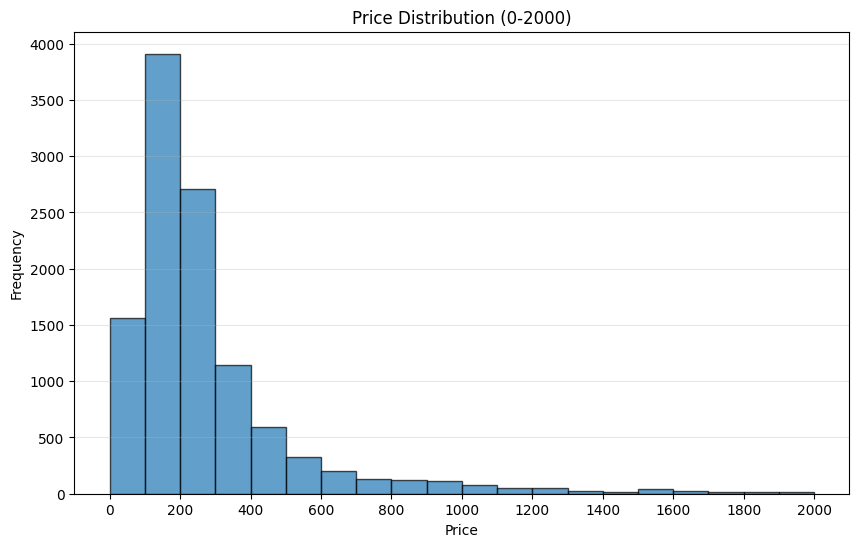

In [18]:
# 读取数据
filtered_data = pd.read_csv("cleaned_data.csv", low_memory=False)

# 尝试找到price列
price_col = None
for col in filtered_data.columns:
    if 'price' in col.lower():
        price_col = col
        break

if price_col is None:
    print("未找到包含'price'的列")
else:
    # 转换为数值类型并删除空值
    filtered_data[price_col] = pd.to_numeric(filtered_data[price_col], errors='coerce')
    price_data = filtered_data[price_col].dropna()
    
    # 过滤0到2000范围内的数据
    price_data = price_data[(price_data > 0) & (price_data <= 2000)]
    
    # 绘制直方图（0-2000，每100一个区间）
    plt.figure(figsize=(10, 6))
    plt.hist(price_data, bins=range(0, 2100, 100), edgecolor='black', alpha=0.7)
    plt.xlabel('Price')
    plt.ylabel('Frequency')
    plt.title('Price Distribution (0-2000)')
    plt.xticks(range(0, 2100, 200))
    plt.grid(axis='y', alpha=0.3)
    plt.show()

From the above information, I decide to classify the price observations into 3 classes: [0-200],[200-400], and [400,]. Now let's find the percentages of them. But if we use this dividing rule, nearly fifty percent of the data belongs to the range of [0-200] class, so I changed the rule into [0,150], [150,300], and [more than 300]

价格区间 [0-150] 的百分比: 30.62%
价格区间 [150-300] 的百分比: 42.78%
价格区间 [300, +∞) 的百分比: 26.59%
总计: 100.00%


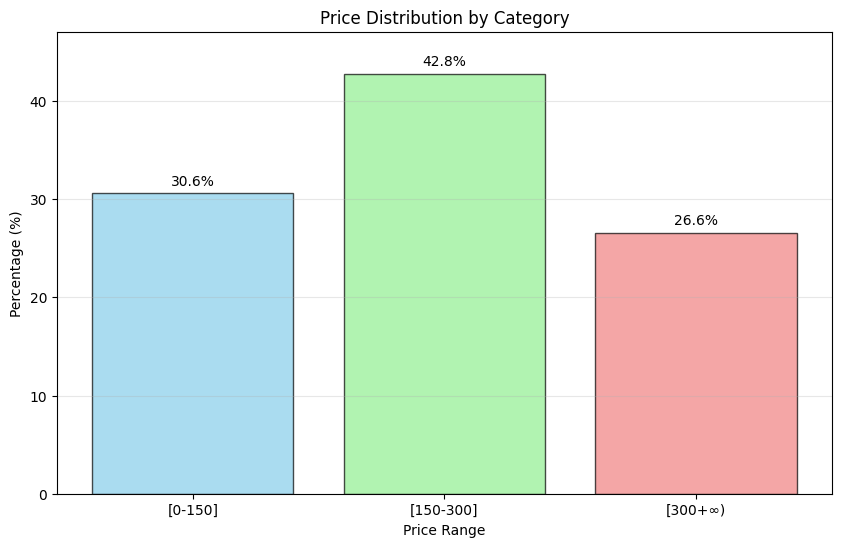

In [19]:
filtered_data = pd.read_csv("cleaned_data.csv", low_memory=False)

# 尝试找到price列
price_col = None
for col in filtered_data.columns:
    if 'price' in col.lower():
        price_col = col
        break

if price_col is None:
    print("未找到包含'price'的列")
else:
    # 转换为数值类型并删除空值
    filtered_data[price_col] = pd.to_numeric(filtered_data[price_col], errors='coerce')
    price_data = filtered_data[price_col].dropna()
    
    # 过滤大于0的数据
    price_data = price_data[price_data > 0]
    
    # 计算三个区间的百分比
    total_count = len(price_data)
    
    range_0_150 = price_data[(price_data >= 0) & (price_data <= 150)]
    range_150_300 = price_data[(price_data > 150) & (price_data <= 300)]
    range_300_plus = price_data[price_data > 300]
    
    percent_0_150 = (len(range_0_150) / total_count) * 100
    percent_150_300 = (len(range_150_300) / total_count) * 100
    percent_300_plus = (len(range_300_plus) / total_count) * 100
    
    print(f"价格区间 [0-150] 的百分比: {percent_0_150:.2f}%")
    print(f"价格区间 [150-300] 的百分比: {percent_150_300:.2f}%")
    print(f"价格区间 [300, +∞) 的百分比: {percent_300_plus:.2f}%")
    print(f"总计: {percent_0_150 + percent_150_300 + percent_300_plus:.2f}%")
    
    # 绘制基于分类的直方图
    categories = ['[0-150]', '[150-300]', '[300+∞)']
    percentages = [percent_0_150, percent_150_300, percent_300_plus]
    
    plt.figure(figsize=(10, 6))
    bars = plt.bar(categories, percentages, color=['skyblue', 'lightgreen', 'lightcoral'], 
                   edgecolor='black', alpha=0.7)
    plt.xlabel('Price Range')
    plt.ylabel('Percentage (%)')
    plt.title('Price Distribution by Category')
    
    # 在柱子上显示百分比数值
    for i, bar in enumerate(bars):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.5,
                f'{percentages[i]:.1f}%', ha='center', va='bottom')
    
    plt.ylim(0, max(percentages) * 1.1)  # 略微增加y轴上限，为标签留出空间
    plt.grid(axis='y', alpha=0.3)
    plt.show()

In [20]:
filtered_data = pd.read_csv("cleaned_data.csv", low_memory=False)

# 尝试找到price列
price_col = None
for col in filtered_data.columns:
    if 'price' in col.lower():
        price_col = col
        break

if price_col is None:
    print("未找到包含'price'的列")
else:
    # 转换price列为数值类型
    filtered_data[price_col] = pd.to_numeric(filtered_data[price_col], errors='coerce')
    
    # 创建price_class列，根据price值分类
    def classify_price(price):
        if pd.isna(price) or price <= 0:
            return None
        elif price < 150:
            return '[0,150)'
        elif price < 300:
            return '[150,300)'
        else:
            return '[300,+)'
    
    # 应用分类函数
    filtered_data['price_class'] = filtered_data[price_col].apply(classify_price)
    
    # 将price_class列移动到第2列位置（索引为1）
    cols = list(filtered_data.columns)
    cols.insert(1, cols.pop(cols.index('price_class')))  # 移除price_class并插入到索引1位置
    filtered_data = filtered_data[cols]
    
    # 显示前几行以验证结果
    print(filtered_data.head())
    
    # 保存结果
    filtered_data.to_csv("cleaned_data_with_price_class.csv", index=False)
    print("已保存包含price_class列的数据到 'cleaned_data_with_price_class.csv'")

        id price_class                         listing_url     scrape_id  \
0  11156.0     [0,150)  https://www.airbnb.com/rooms/11156  2.030000e+13   
1  68999.0     [0,150)  https://www.airbnb.com/rooms/68999  2.030000e+13   
2  71866.0   [150,300)  https://www.airbnb.com/rooms/71866  2.030000e+13   
3  71867.0   [150,300)  https://www.airbnb.com/rooms/71867  2.030000e+13   
4  87709.0     [0,150)  https://www.airbnb.com/rooms/87709  2.030000e+13   

  last_scraped       source                                    name  \
0   17/06/2025  city scrape                    An Oasis in the City   
1   17/06/2025  city scrape      A little bit of Sydney - Australia   
2   17/06/2025  city scrape                A Jewel Amongst Greenery   
3   17/06/2025  city scrape  Quiet and bright apt with green aspect   
4   17/06/2025  city scrape     Room + own Bathroom in Family Home!   

                                         description  \
0  Very central to the city which can be reached ...   
1  H

Then we need to find out the numeric data columns, and try to eliminate all the NAs of them.

In [21]:
df = pd.read_csv("cleaned_data_with_price_class.csv", low_memory=False)

# Identify numeric columns
numeric_cols = []
non_numeric_cols = []

for col in df.columns:
    # Try converting first few non-null values to numeric
    sample = df[col].dropna().head(100)
    if len(sample) > 0:
        # Check if most values can be converted to numeric
        numeric_count = pd.to_numeric(sample, errors='coerce').notna().sum()
        if numeric_count > len(sample) * 0.8:  # 80% threshold
            numeric_cols.append(col)
        else:
            non_numeric_cols.append(col)
    else:
        non_numeric_cols.append(col)

# Replace NAs in numeric columns with -1
for col in numeric_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')
    df[col] = df[col].fillna(-1)

# Replace NAs in non-numeric columns with 'NA'
for col in non_numeric_cols:
    df[col] = df[col].fillna('NA')

# Save the cleaned data
df.to_csv("cleaned_data_with_price_class_no_na.csv", index=False)

print(f"Found {len(numeric_cols)} numeric columns: {numeric_cols}")
print(f"Found {len(non_numeric_cols)} non-numeric columns: {non_numeric_cols}")
print(f"Original data shape: {df.shape}")
print(f"Data processed successfully")

Found 44 numeric columns: ['id', 'scrape_id', 'host_id', 'host_listings_count', 'host_total_listings_count', 'neighbourhood_group_cleansed', 'latitude', 'longitude', 'accommodates', 'bathrooms', 'bedrooms', 'beds', 'price', 'minimum_nights', 'maximum_nights', 'minimum_minimum_nights', 'maximum_minimum_nights', 'minimum_maximum_nights', 'maximum_maximum_nights', 'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm', 'availability_30', 'availability_60', 'availability_90', 'availability_365', 'number_of_reviews', 'number_of_reviews_ltm', 'number_of_reviews_l30d', 'availability_eoy', 'number_of_reviews_ly', 'estimated_occupancy_l365d', 'estimated_revenue_l365d', 'review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication', 'review_scores_location', 'review_scores_value', 'calculated_host_listings_count', 'calculated_host_listings_count_entire_homes', 'calculated_host_listings_count_private_rooms', 'calculated_host_listi

In [24]:
def calculate_missing_rates(df):
    """
    计算每列的缺失率，缺失值定义为'NA'或-1
    
    参数:
    df: pandas DataFrame
    
    返回:
    按缺失率降序排列的Series
    """
    missing_rates = {}
    
    for column in df.columns:
        # 对于数值列，检查-1
        if pd.api.types.is_numeric_dtype(df[column]):
            missing_count = (df[column] == -1).sum()
        # 对于非数值列，检查'NA'和'-1'
        else:
            missing_count = df[column].astype(str).isin(['NA', '-1']).sum()
            
        # 计算缺失率百分比
        missing_rates[column] = (missing_count / len(df)) * 100
    
    # 返回按缺失率排序的结果
    return pd.Series(missing_rates).sort_values(ascending=False)

# 使用示例
df = pd.read_csv("cleaned_data_with_price_class_no_na.csv", low_memory=False)
missing_rates = calculate_missing_rates(df)

# 打印结果
print("各列缺失率(从高到低):")
for column, rate in missing_rates.items():
    print(f"{column}: {rate:.2f}%")

各列缺失率(从高到低):
neighbourhood_group_cleansed: 99.47%
beds: 0.67%
bathrooms: 0.56%
host_total_listings_count: 0.55%
reviews_per_month: 0.53%
maximum_nights_avg_ntm: 0.53%
review_scores_value: 0.53%
longitude: 0.53%
availability_365: 0.53%
estimated_revenue_l365d: 0.52%
host_id: 0.15%
bedrooms: 0.06%
accommodates: 0.04%
latitude: 0.04%
maximum_nights: 0.03%
minimum_nights: 0.03%
minimum_maximum_nights: 0.03%
review_scores_communication: 0.02%
number_of_reviews_l30d: 0.02%
maximum_minimum_nights: 0.02%
review_scores_location: 0.02%
review_scores_checkin: 0.02%
host_listings_count: 0.02%
availability_eoy: 0.02%
maximum_maximum_nights: 0.01%
estimated_occupancy_l365d: 0.01%
minimum_nights_avg_ntm: 0.01%
calculated_host_listings_count_shared_rooms: 0.01%
number_of_reviews_ly: 0.01%
review_scores_accuracy: 0.01%
number_of_reviews: 0.01%
availability_90: 0.00%
calculated_host_listings_count: 0.00%
number_of_reviews_ltm: 0.00%
calendar_last_scraped: 0.00%
calculated_host_listings_count_private_roo